# ABOUT:
- this notebook compares the recommendation performance between Popularity recommender, SAR, and LightGCN on renttherunway dataset

In [1]:
from recommenders.models.sar import SAR
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.evaluation.python_evaluation import precision_at_k
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.utils.timer import Timer

import pandas as pd
import os
import gzip
import json
import pandas as pd
import seaborn as sb

### read data

In [2]:
renttherunway_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\RecSys Datasets\renttherunway_final_data.json.gz"
RUNWAY_COLS = ["user_id", "item_id", "rating", "review_date", "review_summary", "review_text", "rented for", "category", "body type"]

In [3]:
def read_review_data(path):
    def convert_json(json_string):
        try:
            return json.loads(json_string)
        except ValueError:
            return  
    with gzip.open(path, 'r') as fin:                # 4. gzip
        json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)
        json_str = json_bytes.decode('utf-8').split("\n")           # 2. string (i.e. JSON)
        data = []
        for elem in json_str:
            tmp_elem = convert_json(elem)
            if tmp_elem is None:
                continue
            data.append(tmp_elem)
    return data

In [5]:
renttherunway_data = pd.DataFrame(read_review_data(renttherunway_path))
renttherunway_data = renttherunway_data[RUNWAY_COLS]

### data preparation
- preparation for cf training

In [127]:
COLS = ["user_id", "item_id", "rating", "review_date"]
COL_USER, COL_ITEM = "user_id", "item_id"
COL_RATING = "rating"
COL_TIMESTAMP = "review_date"
SPLIT_RATIO = 0.75
SEED = 0 
MIN_INTERACTIONS = 5
TOP_K = 10
BATCH_SIZE = 1024

In [7]:
def clean(df, cols, min_interactions, drop_cold_users = True, drop_cold_items = False):
    output_df = df.copy()
    
    # cleaning
    output_df = output_df.drop_duplicates(subset = [COL_USER, COL_ITEM])
    output_df[COL_RATING] = output_df[COL_RATING].apply(lambda rating: 5 if rating is None else rating)
    output_df[COL_RATING] = output_df[COL_RATING].astype(int)
    
    # find warm items and users
    item_counts = output_df[COL_ITEM].value_counts()
    warm_items = item_counts[item_counts>=min_interactions]
    user_counts = output_df[COL_USER].value_counts()
    warm_users = user_counts[user_counts>=min_interactions]
    
    # keep only warm items and users
    if drop_cold_users:
        output_df = output_df[output_df[COL_USER].isin(warm_users.index)]
    if drop_cold_items:
        output_df = output_df[output_df[COL_ITEM].isin(warm_items.index)]
            
    return output_df

In [8]:
renttherunway_data_reduced = clean(renttherunway_data, cols = COLS, min_interactions = MIN_INTERACTIONS)
renttherunway_data_reduced["review_date"] = pd.to_datetime(renttherunway_data_reduced["review_date"])

In [11]:
print("""
    Reduced Data:
    Total Ratings: {train_total}
    Unique Users: {train_users}
    Unique Items: {train_items}

    Original Data:
    Total Ratings: {test_total}
    Unique Users: {test_users}
    Unique Items: {test_items}
    """.format(
        train_total=len(renttherunway_data_reduced),
        train_users=len(renttherunway_data_reduced[COL_USER].unique()),
        train_items=len(renttherunway_data_reduced[COL_ITEM].unique()),
        test_total=len(renttherunway_data),
        test_users=len(renttherunway_data[COL_USER].unique()),
        test_items=len(renttherunway_data[COL_ITEM].unique()),
))


    Reduced Data:
    Total Ratings: 51100
    Unique Users: 5708
    Unique Items: 5513

    Original Data:
    Total Ratings: 192544
    Unique Users: 105571
    Unique Items: 5850
    


In [12]:
train, test = python_stratified_split(renttherunway_data_reduced, ratio=SPLIT_RATIO,
                                      min_rating=1, filter_by='user', 
                                      col_user=COL_USER, col_item=COL_ITEM, 
                                      seed=SEED)

In [13]:
print("""
    Train Data:
    Total Ratings: {train_total}
    Unique Users: {train_users}
    Unique Items: {train_items}

    Test Data:
    Total Ratings: {test_total}
    Unique Users: {test_users}
    Unique Items: {test_items}
    """.format(
        train_total=len(train),
        train_users=len(train[COL_USER].unique()),
        train_items=len(train[COL_ITEM].unique()),
        test_total=len(test),
        test_users=len(test[COL_USER].unique()),
        test_items=len(test[COL_ITEM].unique()),
))


    Train Data:
    Total Ratings: 38216
    Unique Users: 5708
    Unique Items: 5321

    Test Data:
    Total Ratings: 12884
    Unique Users: 5708
    Unique Items: 4103
    


## Model Training and Evaluation: SAR

In [124]:
# Similarity types: ["cooccurrence" | "cosine" | "inclusion index" | "jaccard" | "lift" | "mutual information" | "lexicographers mutual information"]
model_sar = SAR(
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_timestamp=COL_TIMESTAMP,
    similarity_type="cooccurrence", 
    time_decay_coefficient=30, 
    timedecay_formula=False,
    normalize=False
)

In [125]:
# with Timer() as train_time:
model_sar.fit(train)

In [128]:
top_k = model_sar.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating=COL_RATING, k=TOP_K)
eval_precision  

0.0057988787666433065

## Train and Evaluate: Popularity Recommender

In [65]:
def construct_popular_predictions_table(test, model, top_k):
    user_ids = test.user_id.unique()
    popular_items = model.get_popularity_based_topk(top_k = top_k)
    output = pd.DataFrame()
    for user_id in user_ids:
        popular_items["user_id"] = user_id
        output = pd.concat([output, popular_items], axis = 0)
    return output

In [129]:
top_k = construct_popular_predictions_table(test = test, model = model_sar, top_k = TOP_K)
eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating=COL_RATING, k=TOP_K)
eval_precision  

0.00464260686755431

## Train and Evaluate: LightGCN

In [120]:
yaml_file = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\code1\config\lightgcn.yml"

In [121]:
data = ImplicitCF(train = train, test=test, 
                  adj_dir=None, 
                  col_user=COL_USER, col_item=COL_ITEM, 
                  seed=SEED)

C:\Users\tanch\anaconda3\envs\fyp1\lib\site-packages\recommenders\models\deeprec\DataModel\ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


In [135]:
loss_type = "AmpBPR2"
loss_type = "OriginalBPR"
loss_type = "AmpBPR2"
loss_neg_weight = 1.5
log_wandb = False

In [136]:
hparams = prepare_hparams(yaml_file,
                          n_layers=3,
                          loss_type = loss_type, 
                          loss_neg_weight = loss_neg_weight, 
                          log_wandb = log_wandb,
                          batch_size=BATCH_SIZE,
                          epochs=20,
                          learning_rate=0.0025,
                          eval_epoch=1,
                          top_k=TOP_K,
                          COL_USER = COL_USER,
                          COL_ITEM = COL_ITEM,
                          COL_RATING = COL_RATING
                          )
# initiate model
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [137]:
model.fit()

Epoch 1 (train)2.1s + (eval)0.9s: train loss = 0.69183 = (mf)0.69183 + (embed)0.00000, precision = 0.00431
Epoch 2 (train)1.7s + (eval)0.7s: train loss = 0.67690 = (mf)0.67688 + (embed)0.00002, precision = 0.00485
Epoch 3 (train)1.8s + (eval)0.7s: train loss = 0.62255 = (mf)0.62249 + (embed)0.00006, precision = 0.00478
Epoch 4 (train)1.7s + (eval)0.8s: train loss = 0.54991 = (mf)0.54978 + (embed)0.00013, precision = 0.00487
Epoch 5 (train)1.8s + (eval)0.7s: train loss = 0.49803 = (mf)0.49782 + (embed)0.00021, precision = 0.00498
Epoch 6 (train)1.8s + (eval)0.7s: train loss = 0.46014 = (mf)0.45986 + (embed)0.00028, precision = 0.00517
Epoch 7 (train)1.7s + (eval)0.7s: train loss = 0.43113 = (mf)0.43079 + (embed)0.00034, precision = 0.00534
Epoch 8 (train)1.7s + (eval)0.8s: train loss = 0.40724 = (mf)0.40683 + (embed)0.00040, precision = 0.00536
Epoch 9 (train)1.8s + (eval)0.8s: train loss = 0.38164 = (mf)0.38118 + (embed)0.00046, precision = 0.00548
Epoch 10 (train)1.7s + (eval)0.7s: tr

## Comparison
- Similarities with ML100k:
    - LightGCN > SAR > Popularity
    - LightGCN takes much longer to train and tune, but has shorter inference time
    
- Differences with ML100k:
    - Overall performance in renttherunway is much worse than ML100k

- What we can learn is that both **CF recommenders can improve upon Simple Popularity recommendation**. That means that, if popularity recommendation achieves a score of 0.2 precision@10, we can expect the CF recommenders to improve to let's say 0.25~. But if popularity recommendation achieves a score of only 0.02, then we can expect CF recommenders to improve performances to say only 0.03. **Depending on the type and size of datasets, we can expect vastly different performances**. 

In [108]:
import seaborn as sb

In [138]:
precison_tmp = {
    "LightGCN":0.00608,
    "SAR":0.005799,
    "Popularity":0.003644
} 

[Text(0.5, 0, 'Precision@10')]

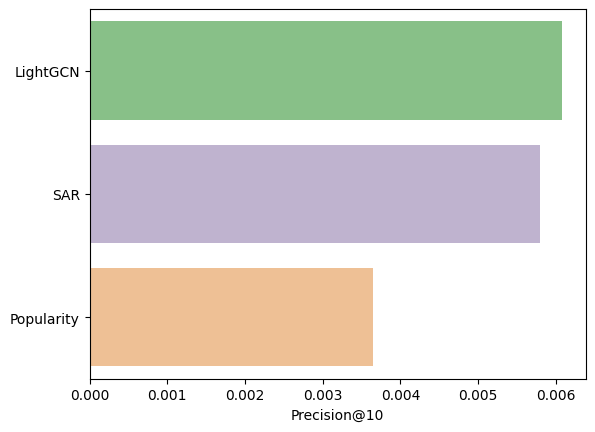

In [139]:
p = sb.barplot(x = list(precison_tmp.values()),y = list(precison_tmp.keys()), palette = "Accent")
p.set(xlabel = "Precision@10")

<!-- ## Train and Evaluate: Popularity Recommender -->

In [112]:
# class PopRecommender():
#     def __init__(self, COL_ITEM = "itemID", COL_USER = "userID"):
#         self.COL_ITEM = COL_ITEM
#         self.COL_USER = COL_USER
#     def fit(self, train):
#         self.train = train
#         self.memory = train[COL_ITEM].value_counts().keys().tolist()
#     def recommend(self, user_id, num_rec = 20, filtered_item_ids = [], remove_seen = True):
#         if remove_seen:
#             remove_item_ids = self._get_user_liked_item_ids(user_id)
#             remove_item_ids += filtered_item_ids
        
#         # recommend num_rec items
#         rec_items = []
#         count = 0
#         for item_id in self.memory:
#             if item_id not in filtered_item_ids: 
#                 count+=1
#                 rec_items.append(item_id)
#             if count >= num_rec:
#                 break
#         return rec_items
    
#     def recommend_k_items(self, test, top_k=10, remove_seen=True):
#         output = pd.DataFrame()
#         for userID in test[self.COL_USER]:
#             rec_items = self.recommend(userID, num_rec = top_k, remove_seen = remove_seen)
#             tmp = pd.DataFrame(rec_items, columns = [self.COL_ITEM])
#             tmp[self.COL_USER] = userID
#             output = pd.concat([output, tmp], axis = 0)
#         output["prediction"] = 1
#         return output
#     def _get_user_liked_item_ids(self, user_id):
#         return self.train[self.train[self.COL_USER] == user_id][self.COL_ITEM].tolist()

In [113]:
# rec = PopRecommender(COL_ITEM = COL_ITEM, COL_USER = COL_USER)
# rec.fit(train)
# top_k = rec.recommend_k_items(test, top_k = TOP_K, remove_seen = True)
# eval_precision = precision_at_k(test, top_k, col_user=COL_USER, col_item=COL_ITEM, col_rating='rating', k=TOP_K)
# eval_precision